# Chapter 3 Choosing and Charaterizing Metrics

## Sample distribution of different metrics under different population distribution

In [13]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.express as px
from tqdm.notebook import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [216]:
# utility
def kstest_against_norm(data):
    """
    Perform KS Test on data.
    
    Parameters
    ----------
    data: numpy array
    
    Return
    ------
    statistic : float
        KS test statistic, either D, D+ or D-.
    pvalue :  float
        One-tailed or two-tailed p-value.
    """
    mu = np.mean(data)
    sd = np.std(data)
    return stats.kstest(data, lambda x: stats.norm.cdf(x, loc = mu, scale = sd))
def adtest_against_norm(data, sig = 5):
    """
    Perform AD test on data
    
    Parameters
    ----------
    data: numpy array
    sig: float
        significance level
    
    Return
    ------
    result: str
        Whether to reject null at particular significance level
    """
    statistic,critical_values,significance_level = stats.anderson(data)
    return f'Reject at alpha = {sig}%' if statistic > critical_values[significance_level == sig] else f'Do not Reject at alpha = {sig}%'

First, We generate population data of latency. Based on Udacity course, we use mixture normal distribution as population. The data distribution is bimodal.

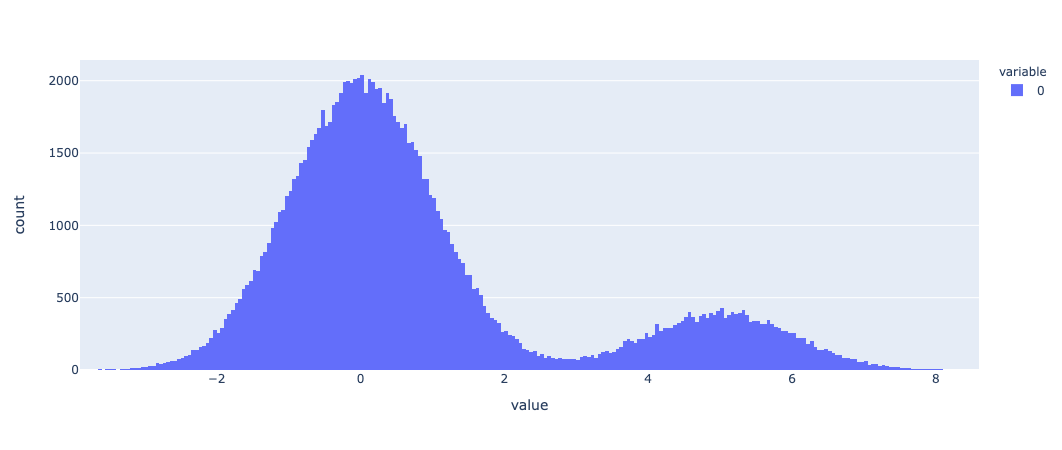

In [255]:
# the population distribution of latency data
population = np.append(stats.norm.rvs(size = 100000,loc = 0, scale = 1), stats.norm.rvs(size = 20000,loc = 5, scale = 1))
px.histogram(population)

Let's bootstrap to get sample distribution of different metrics:

In [251]:
np.mean(sub_sample_q80), np.quantile(population, .8),\
np.mean(sub_sample_q90), np.quantile(population, .9),\
np.mean(sub_sample_q95), np.quantile(population, .95)

(1.7513963773040906,
 1.751612484631135,
 4.751547135714534,
 4.751022307757844,
 5.512316837287825,
 5.51257115653239)

In [204]:
sub_sample_median = []
sub_sample_q80 = []
sub_sample_q90 = []
sub_sample_q95 = []
sub_sample_mean = []
norm_quantile = []
for i in tqdm(range(10000)):
    sub_sample = np.random.choice(population, size = 120000, replace = True)
    sub_sample_median.append(np.median(sub_sample))
    sub_sample_q90.append(np.quantile(sub_sample, q=0.9))
    sub_sample_q80.append(np.quantile(sub_sample, q=0.8))
    sub_sample_q95.append(np.quantile(sub_sample, q=0.95))
    sub_sample_mean.append(np.mean(sub_sample))
    norm_quantile.append(np.quantile(stats.norm.rvs(size = 120000), q = 0.9))

Make plots of sample distributions of metrics:

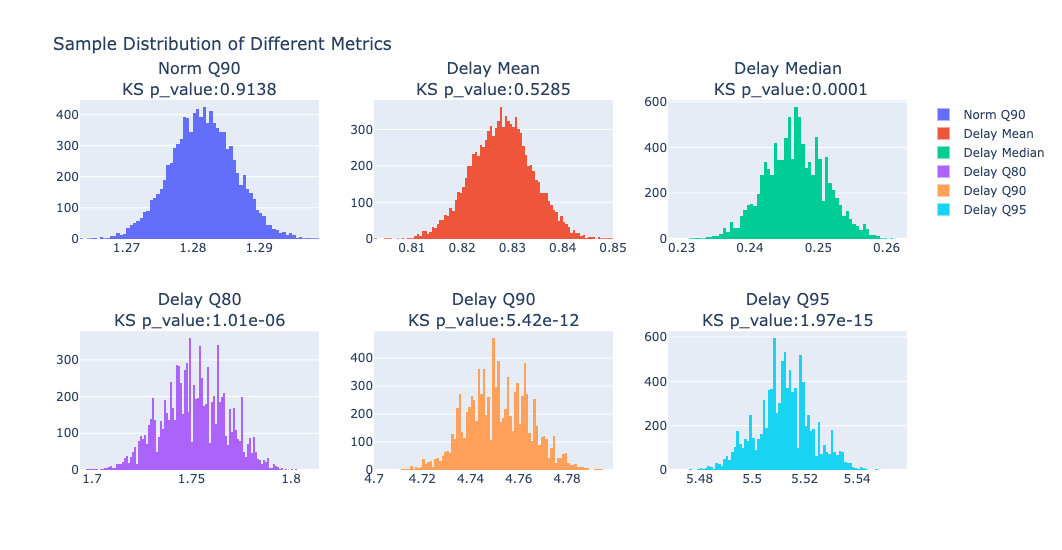

In [211]:
# make subplots of 6 situations:
## metric = Q90 under normal distribution
## metric = (mean, median, Q80, Q90, Q95) under latency distribution
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=("Norm Q90<br>"+f"KS p_value:{kstest_against_norm(norm_quantile)[1]:.4f}",
                                    "Delay Mean<br>"+f"KS p_value:{kstest_against_norm(sub_sample_mean)[1]:.4f}",
                                    "Delay Median<br>"+f" KS p_value:{kstest_against_norm(sub_sample_median)[1]:.4f}",
                                   "Delay Q80<br>"+f"KS p_value:{kstest_against_norm(sub_sample_q80)[1]:.2e}",
                                   "Delay Q90<br>"+f"KS p_value:{kstest_against_norm(sub_sample_q90)[1]:.2e}",
                                   "Delay Q95<br>"+f"KS p_value:{kstest_against_norm(sub_sample_q95)[1]:.2e}"))
fig.add_trace(go.Histogram(x = norm_quantile, name = 'Norm Q90'), row = 1, col = 1)
fig.add_trace(go.Histogram(x = sub_sample_mean, name = 'Delay Mean'), row = 1, col = 2)
fig.add_trace(go.Histogram(x = sub_sample_median, name = 'Delay Median'), row = 1, col = 3)
fig.add_trace(go.Histogram(x = sub_sample_q80, name = 'Delay Q80'), row = 2, col = 1)
fig.add_trace(go.Histogram(x = sub_sample_q90, name = 'Delay Q90'), row = 2, col = 2)
fig.add_trace(go.Histogram(x = sub_sample_q95, name = 'Delay Q95'), row = 2, col = 3)


fig.update_layout(height=550, width=900, title_text="Sample Distribution of Different Metrics")
fig.show()

## AA test/ Bootstrap test for metric variability
- What is the difference between these tests?
  - A/A Tests means you split data into exclusive versions, and compare metric between versions to calculate sample distribution of metric.
  - Bootstrap means you only have 2 version's data and treat them as a big population. Each time, we sample from population data to get a metric difference. We can bootstrap M times to calculate sample distribution of a metric.

In [241]:
data = np.array([-0.05,  0.  ,  0.09, -0.02, -0.01,  0.04, -0.01,  0.  ,  0.02,
       -0.06,  0.05,  0.01,  0.02,  0.02, -0.03,  0.  ,  0.04,  0.01,
        0.04,  0.02, -0.02,  0.03, -0.01,  0.01, -0.02,  0.06,  0.02,
       -0.01,  0.04, -0.02,  0.03,  0.  , -0.06, -0.02, -0.01,  0.08,
       -0.08, -0.03,  0.02, -0.02])

In [243]:
# normal assumption interval
data.mean() - 1.96*data.std(), data.mean() + 1.96*data.std()

(-0.06613112744194995, 0.07463112744194995)

In [244]:
# nonparametric interval
np.quantile(data, q = [.025,.975])

array([-0.0605 ,  0.08025])

## population variance test using Bootstrap

Under normal assumption, F-test can be used to test variance difference. If we do not make parametric assumption on population distribution, how to test variance?

# Chapter 4 Designing an Experiment 

How to define an experiment?
- Choose "Subject"
- Choose "Population"
- Size
- Duration

## Population

In [258]:
p_nz = (374+302)/(6021+5979)
p_global = (374+302+2500+2500)/(6021+5979+50000+50000)

In [261]:
se_nz = np.sqrt(p_nz*(1-p_nz)*(1/6021 + 1/5979))
se_global = np.sqrt(p_global*(1-p_global)*(1/56021 + 1/55979))

In [262]:
# se of estimators
se_nz,se_full

(0.00420953442023799, 0.0013108102809227253)

In [266]:
# test statistics on nz and global
(374/6021 - 302/5979)/se_nz, ((2500+374)/56021 - (302+2500)/55979)/se_nz

(2.7570290866439295, 0.29639988845391374)

# Lesson 5: Analysis Results

## checking variants

In [15]:
import numpy as np
from scipy.stats import norm

In [21]:
n = 15348 + 15312
p = 0.5
se = np.sqrt(p*(1-p)/n)
ci = [p + norm.ppf(0.025)*se, p+norm.ppf(0.975)*se]
# ci = [i*n for i in ci]

In [24]:
15348/n

0.500587084148728

## Single Metric: Example

In [25]:
# data
Xs_cont = [196, 200, 200, 216, 212, 185, 225, 187, 205, 211, 192, 196, 223, 192]
Ns_cont = [2029, 1991, 1951, 1985, 1973, 2021, 2041, 1980, 1951, 1988, 1977, 2019, 2035, 2007]
Xs_exp = [179, 208, 205, 175, 191, 291, 278, 216, 225, 207, 205, 200, 297, 299]
Ns_exp = [1971, 2009, 2049, 2015, 2027, 1979, 1959, 2020, 2049, 2012, 2023, 1981, 1965, 1993]
# we want a effect size, and a sign test result

In [39]:
# sign test result
for i in ['Xs_cont', 'Ns_cont', 'Xs_exp', 'Ns_exp']:
    exec(str(i)+'=np.array('+str(i)+ ')')

In [106]:
from scipy.stats import binom_test
control_ctr = Xs_cont/Ns_cont
treatment_ctr = Xs_exp/Ns_exp
binom_test(sum(treatment_ctr > control_ctr), len(control_ctr), p =0.5,alternative = 'two-sided')

0.4239501953124999

In [125]:
diff = Xs_exp.sum()/Ns_exp.sum() - Xs_cont.sum()/Ns_cont.sum()
diff

0.011601019603516588

In [123]:
se = 0.0062/np.sqrt(1/5000 + 1/5000)*np.sqrt(1/Ns_exp.sum() + 1/Ns_cont.sum())
se

In [126]:
ci = diff + norm.ppf(0.025)*se, diff + norm.ppf(0.975)*se 
ci

(0.006465947856119204, 0.01673609135091397)

In [127]:
(1-norm.cdf(abs(diff/se)))*2

9.515530455139753e-06

In [128]:
61/110

0.5545454545454546

In [129]:
90/200

0.45

In [132]:
1-0.99**10

0.09561792499119559

In [139]:
diff = 10
se = 6.85
(1-norm.cdf(abs(diff/se)))*2,\
(1-norm.cdf(abs(diff/se)))*2*4

(0.14433019982499196, 0.5773207992999678)

# Lesson 6: Final Project

## Calculating Stadard Deviation

In [362]:
# gross conversion: # enroll uid / # "start free button" clk cookie  
p_gc = 0.20625
n_gc = 3200/40000*5000
np.sqrt(p_gc*(1-p_gc)/n_gc).round(4)

0.0202

In [363]:
# Retention: # payment uid / # enroll uid
p_r = 0.53 
n_r = 660/40000*5000
np.sqrt(p_r*(1-p_r)/n_r).round(4)

0.0549

In [364]:
# Net conversion: # payment uid / # "start free button" clk cookie
p_nc = 0.1093125
n_nc = 3200/40000*5000
np.sqrt(p_nc*(1-p_nc)/n_nc).round(4)

0.0156

## Calculating Number of Pageviews

Sample size

We show how to use python power solver/formula instead of a website sample size calculator. The result is slightly different due to decimal rounding.

In [373]:
# use statsmodels' power solver 
from statsmodels.stats.power import tt_ind_solve_power
tt_ind_solve_power(effect_size = 0.01/(p_gc*(1-p_gc))**0.5,alpha=0.05, power = 0.8)*2/(3200/40000)//1 + 1,\
tt_ind_solve_power(effect_size = 0.01/(p_r*(1-p_r))**0.5,alpha=0.05, power = 0.8)*2/(660/40000)//1 + 1,\
tt_ind_solve_power(effect_size = 0.0075/(p_nc*(1-p_nc))**0.5,alpha=0.05, power = 0.8)*2/(3200/40000)//1 +1

(642496.0, 4739876.0, 679304.0)

In [375]:
# use formula
((norm.ppf(0.025) + norm.ppf(0.2))**2*(p_r*(1-p_r))/(0.01)**2)*2 /(660/40000)*2//1 + 1

4739772.0

In [392]:
# website sample size calculator
25835/3200*40000*2//1,\
39115/660*40000*2//1,\
27413/3200*40000*2//1

(645875.0, 4741212.0, 685325.0)

Duration

We need 118 days to test for __Retention__, which is not practical. So, we only use __Gross conversion__ and __Net Conversion__ as evaluation metrics. Net conversions need 17 days to achieve given power. The free trial itself needs 14 days. At last, to get rid of potential weekday effect, we need 35 days as our experiment duration

In [376]:
642496.1756015794/40000,\
4739876.0/40000,\
679304.7155499228/40000

(16.062404390039482, 118.4969, 16.98261788874807)

In [379]:
679304.0/40000 + 14

30.9826

## Sanity Checks

In [393]:
# experiment data
pageviews_cont = np.array([7723, 9102, 10511, 9871, 10014, 9670, 9008, 7434, 8459, 10667, 10660, 9947, 8324, 9434, 8687, 8896, 9535, 9363, 9327, 9345, 8890, 8460, 8836, 9437, 9420, 9570, 9921, 9424, 9010, 9656, 10419, 9880, 10134, 9717, 9192, 8630, 8970])
clicks_cont = np.array([687, 779, 909, 836, 837, 823, 748, 632, 691, 861, 867, 838, 665, 673, 691, 708, 759, 736, 739, 734, 706, 681, 693, 788, 781, 805, 830, 781, 756, 825, 874, 830, 801, 814, 735, 743, 722])
enrollments_cont = np.array([134, 147, 167, 156, 163, 138, 146, 110, 131, 165, 196, 162, 127, 220, 176, 161, 233, 154, 196, 167, 174, 156, 206])
payments_cont = np.array([70, 70, 95, 105, 64, 82, 76, 70, 60, 97, 105, 92, 56, 122, 128, 104, 124, 91, 86, 75, 101, 93, 67])

pageviews_exp = np.array([7716, 9288, 10480, 9867, 9793, 9500, 9088, 7664, 8434, 10496, 10551, 9737, 8176, 9402, 8669, 8881, 9655, 9396, 9262, 9308, 8715, 8448, 8836, 9359, 9427, 9633, 9842, 9272, 8969, 9697, 10445, 9931, 10042, 9721, 9304, 8668, 8988])
clicks_exp = np.array([686, 785, 884, 827, 832, 788, 780, 652, 697, 860, 864, 801, 642, 697, 669, 693, 771, 736, 727, 728, 722, 695, 724, 789, 743, 808, 831, 767, 760, 850, 851, 831, 802, 829, 770, 724, 710])
enrollments_exp = np.array([105, 116, 145, 138, 140, 129, 127, 94, 120, 153, 143, 128, 122, 194, 127, 153, 213, 162, 201, 207, 182, 142, 182])
payments_exp = np.array([34, 91, 79, 92, 94, 61, 44, 62, 77, 98, 71, 70, 68, 94, 81, 101, 119, 120, 96, 67, 123, 100, 103])

In [394]:
# number of cookies
p = 0.5
n = pageviews_exp.sum() + pageviews_cont.sum()
sd = np.sqrt(p*(1-p)/n)
CI = p + norm.ppf(0.025)*sd, p + norm.ppf(0.975)*sd 
print('CI for fraction is:', list(map(lambda x: round(x,4),CI)))
print('Observered fraction is:', round(pageviews_cont.sum()/n,4))

CI for fraction is: [0.4988, 0.5012]
Observered fraction is: 0.5006


In [395]:
# number of clicks on "Start free trial"
p = 0.5
n = clicks_exp.sum() + clicks_cont.sum()
sd = np.sqrt(p*(1-p)/n)
CI = p + norm.ppf(0.025)*sd, p + norm.ppf(0.975)*sd 
print('CI for fraction is:', list(map(lambda x: round(x,4),CI)))
print('Observered fraction is:', round(clicks_cont.sum()/n,4))

CI for fraction is: [0.4959, 0.5041]
Observered fraction is: 0.5005


In [405]:
# Click-through-probability on "start free trial"
# sample statistics
p_cont = clicks_cont.sum()/pageviews_cont.sum()
n_cont = pageviews_cont.sum()
p_exp = clicks_exp.sum()/pageviews_exp.sum()
n_exp = pageviews_exp.sum()

# t test
# diff = p_exp - p_cont
sd = np.sqrt(p_cont*(1-p_cont)/n_cont)
# unpooled_sd = np.sqrt(p_cont*(1-p_cont)/n_cont + p_exp*(1-p_exp)/n_exp)
CI = p_cont+norm.ppf(0.025)*sd, p_cont+norm.ppf(0.975)*sd
print('CI for fraction is:', list(map(lambda x: round(x,4),CI)))
print('Observered fraction is:', round(p_exp,4))


# Click-through-probability on "start free trial"
# sample statistics
# p_cont = clicks_cont.sum()/pageviews_cont.sum()
# n_cont = pageviews_cont.sum()
# p_exp = clicks_exp.sum()/pageviews_exp.sum()
# n_exp = pageviews_exp.sum()

# # t test
# diff = p_exp - p_cont
# unpooled_sd = np.sqrt(p_cont*(1-p_cont)/n_cont + p_exp*(1-p_exp)/n_exp)
# CI = norm.ppf(0.025)*sd, norm.ppf(0.975)*sd
# print('CI for fraction is:', list(map(lambda x: round(x,4),CI)))
# print('Observered fraction is:', round(diff,4))

CI for fraction is: [0.0812, 0.083]
Observered fraction is: 0.0822


### Two different ways for sanity check


In the sanity check above, we only use control's data to compute a confidence interval for population parameter.If the experiment version's estimation fails out of CI, we reject H0 and have evidence that something in experiment goes wrong.Actually, this precedure may have a higher type I error, I will show it in the 2 examples following.

In [406]:
# generate data from Norm(0,1) for cont and exp. And perform sanity check in two calculation percedures of CI.
from tqdm.notebook import tqdm
from scipy.stats import norm
test_CI_1 = 0
test_CI_2 = 0
M = 10000
for i in tqdm(range(M)):
    x = norm.rvs(0,1,1000)
    y = norm.rvs(0,1,1000)
    # CI for mu_x with only use control data. reject H0 if y.mean() fails out of CI.
    CI = x.mean() - norm.ppf(0.975)*x.std()/len(x)**0.5, x.mean() + norm.ppf(0.975)*x.std()/len(x)**0.5
    test_CI_1 += 1 if ((y.mean()<CI[0]) or (y.mean()>CI[1])) else 0
    
    # CI for mu_y - mu_x . reject H0 if diff fails out of CI.
    diff = y.mean()- x.mean()
    sd = np.sqrt(y.var()/y.shape[0] + x.var()/x.shape[0])
    CI = 0 - norm.ppf(0.975)*sd, 0 + norm.ppf(0.975)*sd
    test_CI_2 += 1 if ((diff<CI[0]) or (diff>CI[1])) else 0
print('reject rate in CI_1:', test_CI_1/M, ', which has a higher type I error!')   
print('reject rate in CI_2:', test_CI_2/M)   


reject rate in CI_1: 0.1724 , which has a higher type I error!
reject rate in CI_2: 0.051


In [407]:
# generate data from Bernoulli(1000,0.1) for cont and exp. And perform sanity check in two calculation percedures of CI.
from tqdm.notebook import tqdm
from scipy.stats import bernoulli
test_CI_1 = 0
test_CI_2 = 0
M = 10000
for i in tqdm(range(M)):
    x = bernoulli.rvs(p = 0.1,size =1000)
    y = bernoulli.rvs(p = 0.1,size =1000)
    # CI for mu_x with only use control data. reject H0 if y.mean() fails out of CI.
    CI = x.mean() - norm.ppf(0.975)*x.std()/len(x)**0.5, x.mean() + norm.ppf(0.975)*x.std()/len(x)**0.5
    test_CI_1 += 1 if ((y.mean()<CI[0]) or (y.mean()>CI[1])) else 0
    
    # CI for mu_y - mu_x . reject H0 if diff fails out of CI.
    diff = y.mean()- x.mean()
    sd = np.sqrt(y.var()/y.shape[0] + x.var()/x.shape[0])
    CI = 0 - norm.ppf(0.975)*sd, 0 + norm.ppf(0.975)*sd
    test_CI_2 += 1 if ((diff<CI[0]) or (diff>CI[1])) else 0
print('reject rate in CI_1:', test_CI_1/M, ', which has a higher type I error!')    
print('reject rate in CI_2:', test_CI_2/M)   


reject rate in CI_1: 0.1627 , which has a higher type I error!
reject rate in CI_2: 0.0495


## Effect Size Tests

In [415]:
# Gross conversion
days = len(enrollments_cont) ## quite important
p_cont = enrollments_cont[:days].sum()/clicks_cont[:days].sum()
n_cont = clicks_cont[:days].sum()
p_exp = enrollments_exp[:days].sum()/clicks_exp[:days].sum()
n_exp = clicks_exp[:days].sum()

diff = p_exp - p_cont
sd = np.sqrt(p_cont*(1-p_cont)/n_cont + p_exp*(1-p_exp)/n_exp)

# p_pooled = (p_cont*n_cont + p_exp*n_exp)/(n_cont + n_exp)
# sd = np.sqrt(p_pooled*(1-p_pooled)*(1/n_cont + 1/n_exp))

list(map(lambda x:round(x,4), [diff + norm.ppf(.025)*sd, diff + norm.ppf(.975)*sd])), round(diff,4)

([-0.0291, -0.012], -0.0206)

In [414]:
# New conversion
p_cont = payments_cont[:days].sum()/clicks_cont[:days].sum()
n_cont = clicks_cont[:days].sum()
p_exp = payments_exp[:days].sum()/clicks_exp[:days].sum()
n_exp = clicks_exp[:days].sum()
diff = p_exp - p_cont
sd = np.sqrt(p_cont*(1-p_cont)/n_cont + p_exp*(1-p_exp)/n_exp)

# p_pooled = (p_cont*n_cont + p_exp*n_exp)/(n_cont + n_exp)
# sd = np.sqrt(p_pooled*(1-p_pooled)*(1/n_cont + 1/n_exp))

list(map(lambda x:round(x,4), [diff + norm.ppf(.025)*sd, diff + norm.ppf(.975)*sd])), diff.round(4)

([-0.0116, 0.0019], -0.0049)

## Sign Test

In [410]:
# sign test for Gross conversion
p_cont = enrollments_cont[:days]/clicks_cont[:days]
p_exp = enrollments_exp[:days]/clicks_exp[:days]
binom_test(sum(p_exp>p_cont),days).round(4)

0.0026

In [409]:
# sign test for Net conversion
p_cont = payments_cont[:days]/clicks_cont[:days]
p_exp = payments_exp[:days]/clicks_exp[:days]
binom_test(sum(p_exp>p_cont),days).round(4)

0.6776